# Exercises - Time Series Anomaly Detection

file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb  

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.  

Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening.  

In [12]:
# Imports

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from matplotlib import style
import seaborn as sns
%matplotlib inline

from env import get_connection
pd.plotting.register_matplotlib_converters()

In [13]:
#Define query
query = '''
        SELECT *
        FROM logs
        '''

In [14]:
#Define url
url = get_connection('curriculum_logs')

In [18]:
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [19]:
# set the date as the index and get a daily count of the number of hits per day

df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['path'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

<AxesSubplot:xlabel='date'>

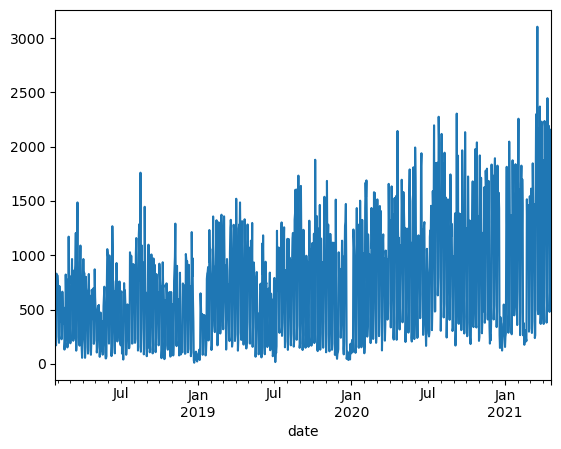

In [20]:
# Visualization of the number of hits by date
pages.plot()


In [21]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()


date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: path, dtype: float64

In [22]:
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()


date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: path, dtype: float64

In [23]:
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()


date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [24]:
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()


date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: path, dtype: float64

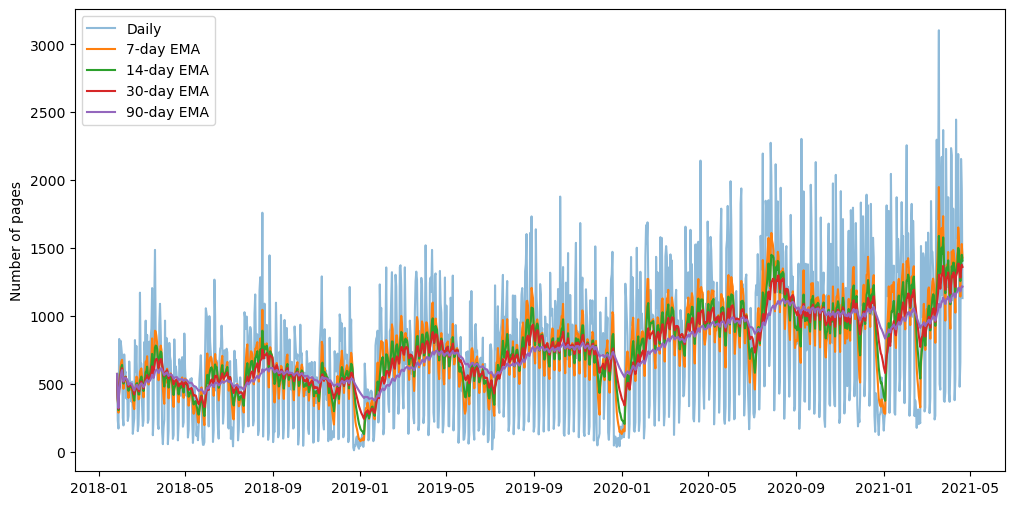

In [26]:
# Visualization that shows the 7, 14, 30, and 90 day ema compared to the current hits. 

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


In [27]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()


date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [28]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()


date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: path, dtype: float64

In [29]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub


date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
                 ...     
2021-04-17    3545.216722
2021-04-18    3486.733695
2021-04-19    3569.147958
2021-04-20    3579.231798
2021-04-21    3499.094360
Freq: D, Name: path, Length: 1182, dtype: float64

In [30]:
# Display the lower bands

lb


date
2018-01-26           NaN
2018-01-27   -330.191557
2018-01-28   -326.494835
2018-01-29   -492.401124
2018-01-30   -352.070116
                 ...    
2021-04-17   -894.858492
2021-04-18   -922.334061
2021-04-19   -891.999913
2021-04-20   -825.770723
2021-04-21   -777.340451
Freq: D, Name: path, Length: 1182, dtype: float64

In [31]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()


,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [32]:
# Add the midband column and pages to the df

my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()


,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


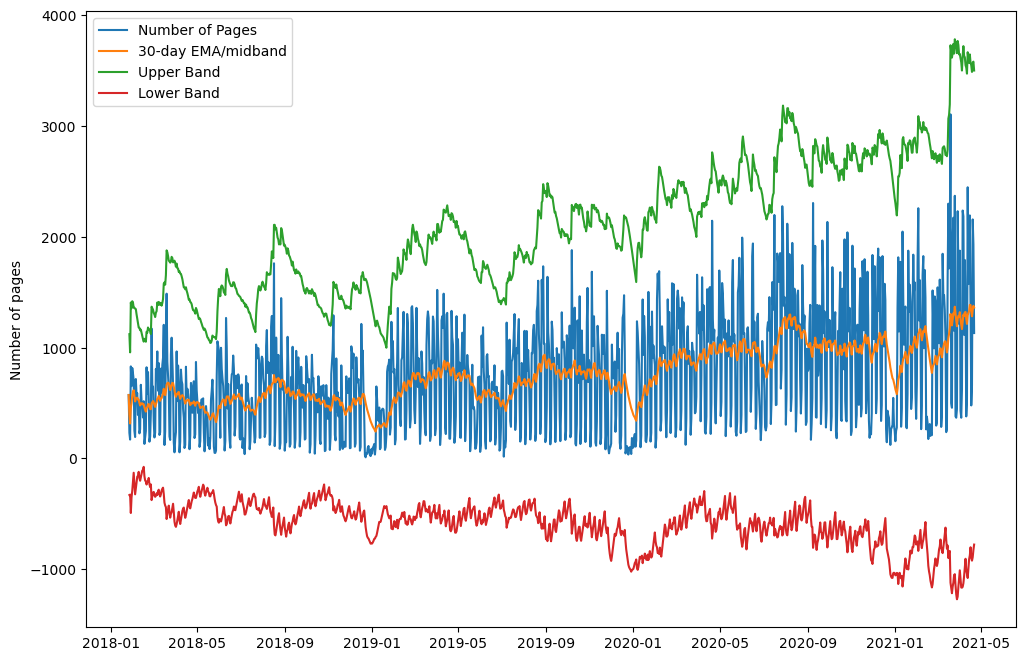

In [33]:
# Plot the bands

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


In [34]:
# get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure


1131.0

In [35]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb


-777.340451135389

In [36]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub


3499.0943598250406

In [37]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))


%b for last datapoint:  0.45


In [38]:
# Display the last three rows

my_df.tail(3)


,pages,midband,ub,lb
date,,,,
2021-04-19,2156,1338.574023,3569.147958,-891.999913
2021-04-20,1930,1376.730537,3579.231798,-825.770723
2021-04-21,1131,1360.876954,3499.094360,-777.340451


In [39]:
#Run the formula with the my_df dataframe

my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()


,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [40]:
# Find where the percent bolinger is greater than one

my_df[my_df['pct_b']>1]


,pages,midband,ub,lb,pct_b
date,,,,,


In [43]:
def acquire(file_name, column_names):
    '''
    This function takes in the file name and column names and reads in the csv with the column names renamed
    '''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    '''
    This function prepares the df by setting the date as the index and resampling by day.
    '''
    # rename the column user_id to user
    df = df[df.user_id == user]
    
    # Converts the date column to a datetime format
    df.date = pd.to_datetime(df.date)
    
    # Sets the date column as the index
    df = df.set_index(df.date)
    
    # Resamples the path column to count the number of hits by day
    pages = df['path'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''
    This function creates the midband, upperband, and lowerband parameters and also creates
    a dataframe with the bands included.
    '''
    # Creating the midband
    midband = pages.ewm(span=span).mean()
    
    # Setting the standard deviation and the span
    stdev = pages.ewm(span=span).std()
    
    # Creating the upperband
    ub = midband + stdev*weight
    
    # Creating the lowerband
    lb = midband - stdev*weight
    
    #  concatenate ub and lb together into one df, bb
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    
    # Creating new column names for pages, midband, upperband, and lowerband
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    
    # un the formula with the my_df dataframe
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    '''
    This function creates a visualization showing the bands.
    '''
    # Creating the figure size and sublots
    fig, ax = plt.subplots(figsize=(12,8))
    
    # The pages plot
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    
    # The midband plot
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    
    # The upper band plot
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    
    # The lower band plot
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    
    # Creating the legend for the plot
    ax.legend(loc='best')
    
    # Renaming the y-axis label
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    '''
    This function finds where the percent bolinger is greater than one.
    '''
    
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]


In [44]:
# Test the find_anomalies function on one user

user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)


In [45]:
# Creating a loop for all of the users

span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)


In [46]:
# Showing the anomalies for every user

anomalies.pages.value_counts(sort=False)


44      4
101     2
9      42
4      76
2      36
       ..
69      1
179     1
99      1
50      2
122     1
Name: pages, Length: 99, dtype: int64

In [47]:
# Showing the anomalies for users with 272 hits

anomalies[anomalies.pages==272]


,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


In [48]:
# Showing the anomalies for users with 341 hits

anomalies[anomalies.user_id==341]


,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2020-02-18,3,0.193548,2.817185,-2.430088,1.034840,341
2020-04-21,109,7.250725,102.413277,-87.911826,1.034608,341
2021-02-09,10,0.659630,9.508602,-8.189342,1.027766,341


In [49]:
# Displaying all the information for users with 341 hits

df[df.user_id==341]


,date,time,path,user_id,cohort_id,ip
date,,,,,,
2019-01-22,2019-01-22,15:23:24,/,341,29.0,97.105.19.58
2019-01-22,2019-01-22,15:25:51,toc,341,29.0,97.105.19.58
2019-01-22,2019-01-22,15:26:44,html-css,341,29.0,97.105.19.58
2019-01-22,2019-01-22,15:28:33,html-css/introduction,341,29.0,97.105.19.58
2019-01-22,2019-01-22,15:29:29,html-css/elements,341,29.0,97.105.19.58
...,...,...,...,...,...,...
2021-02-09,2021-02-09,21:02:55,search/search_index.json,341,29.0,172.124.70.146
2021-02-09,2021-02-09,21:03:20,appendix/further-reading/spring/seeder,341,29.0,172.124.70.146
2021-02-10,2021-02-10,08:31:18,appendix/code-standards/mysql,341,29.0,172.124.70.146
